In [57]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import json
import tensorflow as tf

import matplotlib.pyplot as plt

from signlens.params import *
from signlens.preprocessing.glossary import load_glossary, write_glossary, load_glossary_decoding
from signlens.preprocessing.data import load_data_subset_csv , load_video_list_json
from signlens.preprocessing.preprocess import encode_labels, decode_labels, pad_and_preprocess_sequences_from_pq_file_path_df, preprocess_data_from_json_data, pad_and_preprocess_landmarks_array, reshape_processed_data_to_tf, convert_landmarks_json_data_to_df, filter_relevant_landmarks_and_coordinates
from signlens.model.model_utils import load_model
from signlens.model.model_architecture import evaluate_model
from utils.video_utils import process_video_to_landmarks_json, draw_landmarks_on_image
from utils.plot_landmarks import video_grid_landmarks_2D

from colorama import Fore, Style

%load_ext autoreload

%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Glossary check

In [58]:
#write_glossary()

In [59]:
glossary = load_glossary()

In [60]:
len(glossary.index.unique())

250

In [61]:
glossary_decoding = load_glossary_decoding()
glossary_decoding.head()

,sign
0,book
1,drink
2,before
3,chair
4,go


## Prediction on parquet files

In [62]:
# Load model
model_file = "model_v6_250signs_filtered_pose_epoch_60.keras"
model_path = os.path.join('/home/bfrisque/code/benoitfrisque/signlens/', 'models_api', model_file)
model = load_model(mode='from_path', model_path=model_path)


In [63]:
test_data = load_data_subset_csv(balanced=True, csv_path=TRAIN_TEST_CSV_PATH, random_state=42, frac=0.1)
X_test_files = test_data.file_path

# Preprocessing
print(Fore.BLUE + f"\nPreprocessing {len(X_test_files)} testing files..." + Style.RESET_ALL)
X_test = pad_and_preprocess_sequences_from_pq_file_path_df(X_test_files)
y_test = encode_labels(test_data.sign)


metrics_dict = evaluate_model(model, X_test, y_test)
accuracy = metrics_dict['accuracy']


Loading data subset from train_test.csv
    ℹ️ Random state set for data loading : 42
    ℹ️ Filtered sequences with missing frames. Size reduced from 17233 to 17233 (100.00%)
    ℹ️ Filtered on n_frames = 100. Size reduced from 17233 to 17233 (100.00%)
    ℹ️ Filtered on n_classes = 250. Size reduced from 17233 to 17233 (100.00%)
    ℹ️ Balanced data, with average of 6.9 elements per class. Size reduced from 17233 to 1723 (10.00%)
✅ Loaded 1723 rows (10.00% of the original 17233 rows) from the dataset.

Preprocessing 1723 testing files...


/home/bfrisque/.pyenv/versions/3.10.6/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()

100%|█████████████████████████████████████████████████████████████████████████████████| 1723/1723 [00:05<00:00, 310.41it/s]



Evaluating model on 1723 rows...
✅ Model evaluated, accuracy: 55.7%


### Check of parquet file landmarks

In [72]:
data_columns = ['frame', 'type', 'x', 'y', 'z']
data = pd.read_parquet(X_test_files[0], columns=data_columns)
print(len(data))
print(len(data[data.type == 'left_hand']))
print(len(data[data.type == 'right_hand']))
print(len(data[data.type == 'pose']))

n_frames = data.frame.nunique()
print(n_frames)
print(N_LANDMARKS_HAND)
data_left_hand = data[data.type == 'left_hand'][[
    'x', 'y', 'z']].values.reshape(n_frames, N_LANDMARKS_HAND, 3)
data_right_hand = data[data.type == 'right_hand'][[
    'x', 'y', 'z']].values.reshape(n_frames, N_LANDMARKS_HAND, 3)

2100
588
588
924
28
21


In [80]:
data_pose = data[data.type == 'pose'][['x', 'y', 'z']
                                          ].values.reshape(n_frames, N_LANDMARKS_POSE_TOTAL, 3)

In [78]:
video_grid_landmarks_2D(test_data, sign="dad", n_videos=3)

--------------------
dad
--------------------


GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

## Prediction on json from videos

### Select test set

In [10]:
videos = load_video_list_json(filter_glossary=True)

In [19]:
# test_videos = videos.sample(n=500, random_state=42)
test_videos = videos.sample(n=30, random_state=42)

In [20]:
test_videos 

,sign,bbox,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,video_path
1125,on,"[29, 0, 267, 240]",25,-1,1,3,37,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/4...,0,39839,/home/bfrisque/code/benoitfrisque/signlens/raw...
184,white,"[183, 52, 544, 400]",25,-1,1,16,12,aslsearch,train,http://www.aslsearch.com/signs/videos/white.mp4,0,63214,/home/bfrisque/code/benoitfrisque/signlens/raw...
1226,water,"[89, 22, 204, 192]",25,-1,1,6,10,signingsavvy,train,https://www.signingsavvy.com/signs/mp4/22/2297...,0,62506,/home/bfrisque/code/benoitfrisque/signlens/raw...
67,jump,"[167, 16, 480, 370]",25,-1,1,1,90,aslsignbank,train,https://aslsignbank.haskins.yale.edu/dictionar...,0,65983,/home/bfrisque/code/benoitfrisque/signlens/raw...
220,yes,"[168, 14, 461, 370]",25,-1,1,13,88,aslsignbank,train,https://aslsignbank.haskins.yale.edu/dictionar...,0,66820,/home/bfrisque/code/benoitfrisque/signlens/raw...
903,sick,"[250, 30, 912, 720]",25,-1,1,1,118,aslbrick,test,http://aslbricks.org/New/ASL-Videos/sick.mp4,0,69470,/home/bfrisque/code/benoitfrisque/signlens/raw...
430,read,"[42, 0, 252, 240]",25,-1,1,8,37,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/4...,0,46266,/home/bfrisque/code/benoitfrisque/signlens/raw...
240,fish,"[98, 12, 236, 180]",25,-1,1,16,19,elementalasl,val,https://elementalaslconcepts.weebly.com/upload...,1,22113,/home/bfrisque/code/benoitfrisque/signlens/raw...
218,apple,"[212, 17, 526, 414]",25,-1,1,17,36,startasl,train,https://s3-us-west-1.amazonaws.com/files.start...,0,03002,/home/bfrisque/code/benoitfrisque/signlens/raw...
49,hello,"[34, 11, 536, 480]",25,-1,1,12,21,asldeafined,train,https://media.asldeafined.com/vocabulary/14685...,0,27173,/home/bfrisque/code/benoitfrisque/signlens/raw...


In [21]:
test_videos['sign']

1125         on
184       white
1226      water
67         jump
220         yes
903        sick
430        read
240        fish
218       apple
49        hello
816        make
844         can
619        drop
361       green
1429      drink
873        open
1439    bedroom
754        hair
271       tooth
522       awake
259      listen
428      police
1167    because
277     because
968        rain
570        book
672       snack
621       cloud
1049      dance
247         arm
Name: sign, dtype: object

In [22]:
test_videos['sign'].nunique()

29

In [23]:
test_videos['sign'].value_counts()

sign
because    2
on         1
open       1
dance      1
cloud      1
snack      1
book       1
rain       1
police     1
listen     1
awake      1
tooth      1
hair       1
bedroom    1
drink      1
white      1
green      1
drop       1
can        1
make       1
hello      1
apple      1
fish       1
read       1
sick       1
yes        1
jump       1
water      1
arm        1
Name: count, dtype: int64

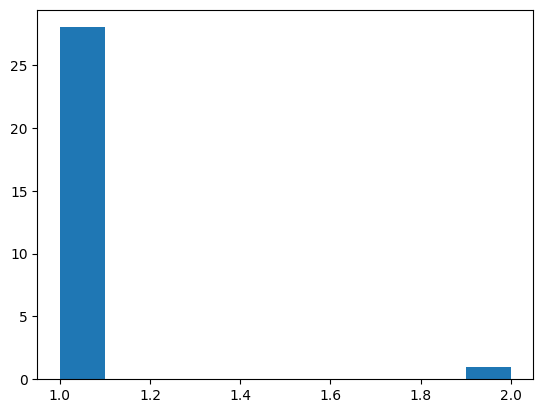

In [24]:
plt.hist(test_videos['sign'].value_counts());

### Convert videos to json

In [47]:
import os
import json
import numpy as np
import mediapipe as mp
import cv2
import math
from google.protobuf.json_format import MessageToDict
from mediapipe.framework.formats import landmark_pb2
from mediapipe import solutions

mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands

# Constants for drawing landmarks on the image
MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54)  # vibrant green


def serialize_landmarks(landmark_list):
    """
    Serialize a list of landmarks into a dictionary format.

    Args:
        landmark_list (list): A list of landmarks.

    Returns:
        list: A list of dictionaries, where each dictionary represents a landmark and contains the following keys:
            - 'landmark_index': The index of the landmark in the list.
            - 'x': The x-coordinate of the landmark. If the value is NaN, it is set to None.
            - 'y': The y-coordinate of the landmark. If the value is NaN, it is set to None.
            - 'z': The z-coordinate of the landmark. If the value is NaN, it is set to None.
    """
    landmarks = []
    for idx, landmark in enumerate(landmark_list.landmark):
        landmarks.append({
            'landmark_index': idx,
            'x': None if math.isnan(landmark.x) else landmark.x,
            'y': None if math.isnan(landmark.y) else landmark.y,
            'z': None if math.isnan(landmark.z) else landmark.z
        })
    return landmarks


def process_video_to_landmarks_json2(video_path, json_output=True, save_annotated_video=False, show_preview=True, frame_interval=1, frame_limit=None, rear_camera=True, output_dir=LANDMARKS_VIDEO_DIR, skip_existing=False):
    """
    Process a video file and extract landmarks from each frame, then save the landmarks as JSON.
    Inspired from https://github.com/google/mediapipe/blob/master/docs/solutions/hands.md

    Args:
        video_path (str): The path to the video file.
        json_output (bool, optional): Whether to save the landmarks as JSON. Defaults to True.
        show_preview (bool, optional): Whether to show a preview of the processed frames. Defaults to True.
        frame_interval (int, optional): The interval between processed frames. Defaults to 1.
        frame_limit (int, optional): The maximum number of frames to process. Defaults to None.
        rear_camera (bool, optional): Whether the video was recorded with a rear camera. Defaults to True.
        output_dir (str, optional): The directory to save the landmarks JSON file. Defaults to LANDMARKS_VIDEO_DIR.

    Returns:
        list: A list of dictionaries containing the extracted landmarks for each frame.

    Raises:
        FileNotFoundError: If the video file specified by `video_path` does not exist.

    Example:
        video_path = '/path/to/video.mp4'
        landmarks = process_video_to_landmarks_json(video_path, output=True, frame_interval=2, frame_limit=100)
        print(landmarks)
    """
    filename = os.path.splitext(os.path.basename(video_path))[0]

    # Open video file
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"Video file '{video_path}' not found.")

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video file '{video_path}'")
        return

    json_data = []
    frame_number = 0
    processed_frames = 0
    loop_complete = False

    # Prepare JSON file
    os.makedirs(output_dir, exist_ok=True)
    json_path = os.path.join(output_dir, f'{filename}_landmarks.json')

    if os.path.exists(json_path) and skip_existing:
        print(f"Skipping video '{filename}' as landmarks file already exists.")
        return

    # Get the fps of the original video
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Get the frame width and height
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    try:
        if json_output:
            json_file = open(json_path, 'w', encoding='UTF8')

        # Initialize preview window
        if show_preview:
            cv2_window_name = f"Video {filename}"
            cv2.namedWindow(cv2_window_name, cv2.WINDOW_NORMAL) # create empty window
            move_window_to_center(cv2_window_name, frame_width, frame_height)

        # Initialize video writer
        if save_annotated_video:
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or use 'XVID'
            annotated_video_path = os.path.join(output_dir, f'{filename}_annotated.mp4')
            out = cv2.VideoWriter(annotated_video_path, fourcc, fps, (frame_width, frame_height))

        # Initialize an empty NormalizedLandmarkList for hand and pose
        empty_hand_landmark_list = create_empty_landmark_list(N_LANDMARKS_HAND)
        empty_pose_landmark_list = create_empty_landmark_list(N_LANDMARKS_POSE)

        # Initialize mediapipe instances
        with mp_pose.Pose(static_image_mode=False) as pose, \
                mp_hands.Hands(static_image_mode=False, max_num_hands=2) as hands:
            while cap.isOpened():
                success, frame = cap.read()
                if not success:
                    break

                # Skip frames based on frame_interval
                if frame_number % frame_interval != 0:
                    frame_number += 1
                    continue

                # Convert the BGR image to RGB
                image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                # Process the image and extract landmarks
                results_pose = pose.process(image_rgb)
                results_hands = hands.process(image_rgb)

                if show_preview or save_annotated_video:
                    # Draw landmarks on the image
                    annotated_image = draw_landmarks_on_image(image_rgb, results_pose, results_hands, rear_camera)
                    annotated_image_color = cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR)

                    if show_preview:
                        cv2.imshow(cv2_window_name, annotated_image_color)
                        if cv2.waitKey(1) & 0xFF == ord('q'):
                            break

                    if save_annotated_video:
                        out.write(annotated_image_color)

                # Extract landmarks for pose, left hand, and right hand
                landmarks_pose = results_pose.pose_landmarks

                # Check if there are any pose landmarks detected
                if landmarks_pose is None:
                    landmarks_pose = empty_pose_landmark_list

                # Initialize empty hand landmarkks, then overwrite if it finds it
                landmarks_left_hand = empty_hand_landmark_list
                landmarks_right_hand = empty_hand_landmark_list

                # Check if there are any hand landmarks detected
                if results_hands.multi_hand_landmarks:
                    # Get handedness of each hand
                    for idx, handedness in enumerate(results_hands.multi_handedness):
                        hand_side = get_hand_side(handedness, rear_camera)

                        if hand_side == 'left':
                            landmarks_left_hand = results_hands.multi_hand_landmarks[idx]
                        elif hand_side == 'right':
                            landmarks_right_hand = results_hands.multi_hand_landmarks[idx]

                serialized_pose = serialize_landmarks(landmarks_pose)
                serialized_left_hand = serialize_landmarks(landmarks_left_hand)
                serialized_right_hand = serialize_landmarks(landmarks_right_hand)

                # Write serialized landmarks to JSON
                json_data.append({
                    'frame_number': frame_number,
                    'pose': serialized_pose,
                    'left_hand': serialized_left_hand,
                    'right_hand': serialized_right_hand
                })

                frame_number += 1
                processed_frames += 1

                # Stop processing if frame_limit is reached
                if frame_limit is not None and processed_frames >= frame_limit:
                    break

        if json_output:
            # Write JSON data to file
            json.dump(json_data, json_file, indent=4)
            print(f"✅ Landmarks saved to '{json_path}'")

        loop_complete = True

    except KeyboardInterrupt:
        print("Process interrupted by user.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:

        cap.release()  # Close video file

        if show_preview and cv2.getWindowProperty(cv2_window_name, 0) >= 0:
            cv2.destroyWindow(cv2_window_name)  # close preview window

        if json_output and json_file is not None:
            # Close file
            json_file.close()

        if json_output and not loop_complete:
            # Remove JSON file if loop was not completed
            os.remove(json_path)
            print(f"❌ Landmarks file '{json_path}' not written properly.")

        if save_annotated_video:
            out.release()
            print(f"✅ Annotated video saved to '{annotated_video_path}'")

    return json_data

def create_empty_landmark_list(n_landmarks):
    """
    Create an empty NormalizedLandmarkList.

    Args:
        n_landmarks (int): The number of landmarks to create.

    Returns:
        landmark_pb2.NormalizedLandmarkList: An empty NormalizedLandmarkList.

    """
    # Initialize an empty NormalizedLandmarkList for hand
    empty_landmark_list = landmark_pb2.NormalizedLandmarkList()

    # Add empty landmarks to the list
    for _ in range(n_landmarks):
        landmark = empty_landmark_list.landmark.add()
        landmark.x = np.nan  # We use nan and not None because it doesn't work with None
        landmark.y = np.nan
        landmark.z = np.nan

    return empty_landmark_list


def get_hand_side(handedness, rear_camera):
    """
    Determines the side of the hand based on the handedness classification.

    Args:
        handedness (protobuf message): The handedness classification message.
        rear_camera (bool): Flag indicating whether the input image is taken with a rear camera.

    Returns:
        str: The side of the hand ('left' or 'right').

    Notes:
        By default, mediapipe assumes the input image is mirrored, i.e., taken with a front-facing/selfie camera with images flipped horizontally.
        If you want to process images taken with a webcam/selfie, you can set rear_camera = False.
    """
    handedness_dict = MessageToDict(handedness)
    hand_side = handedness_dict['classification'][0]['label'].lower()

    if rear_camera:
        if hand_side == 'left':
            hand_side = 'right'
        elif hand_side == 'right':
            hand_side = 'left'

    return hand_side


def draw_landmarks_on_image(rgb_image, results_pose, results_hands, rear_camera):
    """
    Draws landmarks on the given RGB image based on the detected hand landmarks.

    Args:
            rgb_image (numpy.ndarray): The RGB image on which to draw the landmarks.
            results_pose (mediapipe.python.solution_base.SolutionOutputs): The output of the pose detection model.
            results_hands (mediapipe.python.solution_base.SolutionOutputs): The output of the hand detection model.
            rear_camera (bool): Flag indicating whether the camera is rear-facing or not.

    Returns:
            numpy.ndarray: The annotated image with landmarks drawn.

    Note:
            It is normal to see the left hand on the right side and the right hand on the left side if rear_camera=True.
    """

    annotated_image = np.copy(rgb_image)

    if results_hands.multi_hand_landmarks is None and results_pose is None:
        return annotated_image

    if results_hands.multi_hand_landmarks is not None:
        # Loop through the detected hands to visualize.
        for idx in range(len(results_hands.multi_hand_landmarks)):
            hand_landmarks = results_hands.multi_hand_landmarks[idx].landmark
            handedness = results_hands.multi_handedness[idx]
            hand_side = get_hand_side(handedness, rear_camera)

            hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
            hand_landmarks_proto.landmark.extend([
                landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
            ])

            # Draw the hand landmarks.
            solutions.drawing_utils.draw_landmarks(
                annotated_image,
                hand_landmarks_proto,
                solutions.hands.HAND_CONNECTIONS,
                solutions.drawing_styles.get_default_hand_landmarks_style(),
                solutions.drawing_styles.get_default_hand_connections_style())

            # Get the top left corner of the detected hand's bounding box.
            height, width, _ = annotated_image.shape
            x_coordinates = [landmark.x for landmark in hand_landmarks]
            y_coordinates = [landmark.y for landmark in hand_landmarks]
            text_x = int(min(x_coordinates) * width)
            text_y = int(min(y_coordinates) * height) - MARGIN

            # Draw handedness (left or right hand) on the image.
            cv2.putText(annotated_image, f"{hand_side}",
                        (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                        FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

        if results_pose is not None:
            pose_landmarks = results_pose.pose_landmarks.landmark

            pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
            pose_landmarks_proto.landmark.extend([
                landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
            ])

          # Draw the pose landmarks.
            solutions.drawing_utils.draw_landmarks(
                annotated_image,
                pose_landmarks_proto,
                solutions.pose.POSE_CONNECTIONS,
                solutions.drawing_styles.get_default_pose_landmarks_style())

    return annotated_image


def move_window_to_center(cv2_window_name, frame_width, frame_height):

    if cv2.getWindowProperty(cv2_window_name, 0) >= 0: # Check if the window is still open

        try:
            # Get the screen size
            from screeninfo import get_monitors
            screen_width = get_monitors()[0].width
            screen_height = get_monitors()[0].height
        except ImportError:
            print("screeninfo module not found, using default screen size.")
            screen_width = 800
            screen_height = 600

        # Calculate the position to place the window in the middle of the screen
        window_x = screen_width // 2 - frame_width // 2
        window_y = screen_height // 2 - frame_height // 2

        # Move the window to the calculated position
        cv2.moveWindow(cv2_window_name, window_x, window_y)
        cv2.resizeWindow(cv2_window_name, frame_width, frame_height)


In [48]:
def process_video_sequential(video_path_df):
    # Initialize a list to store the results
    results = []

    # Create a progress bar
    progress_bar = tqdm(total=len(video_path_df), desc="Processing videos")

    # Iterate over the video paths
    for video_path in video_path_df:
        # Process the video and store the result
        process_video_to_landmarks_json2(video_path, json_output=True, show_preview=False, save_annotated_video=True, frame_interval=1, rear_camera=True, skip_existing=False)

        # Update the progress bar
        progress_bar.update(1)


In [49]:
process_video_sequential(test_videos.video_path)


Processing videos:   0%|                                                                            | 0/30 [00:00<?, ?it/s]INFO: Created TensorFlow Lite XNNPACK delegate for CPU.

Processing videos:   3%|██▎                                                                 | 1/30 [00:05<02:27,  5.09s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/39839_landmarks.json'
✅ Annotated video saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/39839_annotated.mp4'



Processing videos:   7%|████▌                                                               | 2/30 [00:12<03:03,  6.56s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/63214_landmarks.json'
✅ Annotated video saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/63214_annotated.mp4'



Processing videos:  10%|██████▊                                                             | 3/30 [00:17<02:36,  5.81s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/62506_landmarks.json'
✅ Annotated video saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/62506_annotated.mp4'



Processing videos:  13%|█████████                                                           | 4/30 [00:23<02:29,  5.74s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/65983_landmarks.json'
✅ Annotated video saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/65983_annotated.mp4'



Processing videos:  17%|███████████▎                                                        | 5/30 [00:27<02:08,  5.15s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/66820_landmarks.json'
✅ Annotated video saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/66820_annotated.mp4'



Processing videos:  20%|█████████████▌                                                      | 6/30 [00:33<02:14,  5.62s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/69470_landmarks.json'
✅ Annotated video saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/69470_annotated.mp4'



Processing videos:  23%|███████████████▊                                                    | 7/30 [00:40<02:13,  5.80s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/46266_landmarks.json'
✅ Annotated video saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/46266_annotated.mp4'



Processing videos:  27%|██████████████████▏                                                 | 8/30 [00:50<02:38,  7.20s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/22113_landmarks.json'
✅ Annotated video saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/22113_annotated.mp4'



Processing videos:  30%|████████████████████▍                                               | 9/30 [00:56<02:22,  6.78s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/03002_landmarks.json'
✅ Annotated video saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/03002_annotated.mp4'



Processing videos:  33%|██████████████████████▎                                            | 10/30 [01:03<02:20,  7.05s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/27173_landmarks.json'
✅ Annotated video saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/27173_annotated.mp4'



Processing videos:  37%|████████████████████████▌                                          | 11/30 [01:09<02:07,  6.73s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/34580_landmarks.json'
✅ Annotated video saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/34580_annotated.mp4'



Processing videos:  40%|██████████████████████████▊                                        | 12/30 [01:20<02:22,  7.94s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/08937_landmarks.json'
✅ Annotated video saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/08937_annotated.mp4'



Processing videos:  43%|█████████████████████████████                                      | 13/30 [01:28<02:15,  7.95s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/17832_landmarks.json'
✅ Annotated video saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/17832_annotated.mp4'



Processing videos:  47%|███████████████████████████████▎                                   | 14/30 [01:39<02:19,  8.74s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/25686_landmarks.json'
✅ Annotated video saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/25686_annotated.mp4'



Processing videos:  50%|█████████████████████████████████▌                                 | 15/30 [01:43<01:52,  7.51s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/17724_landmarks.json'
✅ Annotated video saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/17724_annotated.mp4'



Processing videos:  53%|███████████████████████████████████▋                               | 16/30 [01:52<01:51,  7.94s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/39951_landmarks.json'
✅ Annotated video saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/39951_annotated.mp4'



Processing videos:  57%|█████████████████████████████████████▉                             | 17/30 [02:01<01:45,  8.14s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/05661_landmarks.json'
✅ Annotated video saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/05661_annotated.mp4'



Processing videos:  60%|████████████████████████████████████████▏                          | 18/30 [02:07<01:32,  7.68s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/26174_landmarks.json'
✅ Annotated video saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/26174_annotated.mp4'



Processing videos:  63%|██████████████████████████████████████████▍                        | 19/30 [02:15<01:23,  7.57s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/58908_landmarks.json'
✅ Annotated video saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/58908_annotated.mp4'



Processing videos:  67%|████████████████████████████████████████████▋                      | 20/30 [02:17<00:59,  5.99s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/04358_landmarks.json'
✅ Annotated video saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/04358_annotated.mp4'



Processing videos:  70%|██████████████████████████████████████████████▉                    | 21/30 [02:25<01:00,  6.74s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/33466_landmarks.json'
✅ Annotated video saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/33466_annotated.mp4'



Processing videos:  73%|█████████████████████████████████████████████████▏                 | 22/30 [02:31<00:51,  6.42s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/66306_landmarks.json'
✅ Annotated video saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/66306_annotated.mp4'



Processing videos:  77%|███████████████████████████████████████████████████▎               | 23/30 [02:35<00:39,  5.64s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/05598_landmarks.json'
✅ Annotated video saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/05598_annotated.mp4'



Processing videos:  80%|█████████████████████████████████████████████████████▌             | 24/30 [02:40<00:32,  5.50s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/65158_landmarks.json'
✅ Annotated video saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/65158_annotated.mp4'



Processing videos:  83%|███████████████████████████████████████████████████████▊           | 25/30 [02:48<00:30,  6.17s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/46001_landmarks.json'
✅ Annotated video saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/46001_annotated.mp4'



Processing videos:  87%|██████████████████████████████████████████████████████████         | 26/30 [02:51<00:21,  5.36s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/07074_landmarks.json'
✅ Annotated video saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/07074_annotated.mp4'



Processing videos:  90%|████████████████████████████████████████████████████████████▎      | 27/30 [02:56<00:15,  5.19s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/52691_landmarks.json'
✅ Annotated video saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/52691_annotated.mp4'



Processing videos:  93%|██████████████████████████████████████████████████████████████▌    | 28/30 [03:04<00:12,  6.06s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/11358_landmarks.json'
✅ Annotated video saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/11358_annotated.mp4'



Processing videos:  97%|████████████████████████████████████████████████████████████████▊  | 29/30 [03:14<00:07,  7.24s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/14623_landmarks.json'
✅ Annotated video saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/14623_annotated.mp4'



Processing videos: 100%|███████████████████████████████████████████████████████████████████| 30/30 [03:18<00:00,  6.63s/it]

✅ Landmarks saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/03338_landmarks.json'
✅ Annotated video saved to '/home/bfrisque/code/benoitfrisque/signlens/processed_data/landmarks_videos/03338_annotated.mp4'


In [45]:
# create json_path column
test_videos['json_path'] = test_videos['video_path'].apply(lambda x: os.path.join(LANDMARKS_VIDEO_DIR, f'{os.path.splitext(os.path.basename(x))[0]}_landmarks.json'))
test_videos.head()

,sign,bbox,fps,frame_end,frame_start,instance_id,signer_id,source,split,url,variation_id,video_id,video_path,json_path
1125,on,"[29, 0, 267, 240]",25,-1,1,3,37,spreadthesign,train,https://media.spreadthesign.com/video/mp4/13/4...,0,39839,/home/bfrisque/code/benoitfrisque/signlens/raw...,/home/bfrisque/code/benoitfrisque/signlens/pro...
184,white,"[183, 52, 544, 400]",25,-1,1,16,12,aslsearch,train,http://www.aslsearch.com/signs/videos/white.mp4,0,63214,/home/bfrisque/code/benoitfrisque/signlens/raw...,/home/bfrisque/code/benoitfrisque/signlens/pro...
1226,water,"[89, 22, 204, 192]",25,-1,1,6,10,signingsavvy,train,https://www.signingsavvy.com/signs/mp4/22/2297...,0,62506,/home/bfrisque/code/benoitfrisque/signlens/raw...,/home/bfrisque/code/benoitfrisque/signlens/pro...
67,jump,"[167, 16, 480, 370]",25,-1,1,1,90,aslsignbank,train,https://aslsignbank.haskins.yale.edu/dictionar...,0,65983,/home/bfrisque/code/benoitfrisque/signlens/raw...,/home/bfrisque/code/benoitfrisque/signlens/pro...
220,yes,"[168, 14, 461, 370]",25,-1,1,13,88,aslsignbank,train,https://aslsignbank.haskins.yale.edu/dictionar...,0,66820,/home/bfrisque/code/benoitfrisque/signlens/raw...,/home/bfrisque/code/benoitfrisque/signlens/pro...


### Preprocess json

In [28]:
json_path = test_videos.json_path.iloc[0]

with open(json_path) as f:
    json_data = json.load(f)

data_processed_tf = preprocess_data_from_json_data(json_data)

In [29]:
# Initialize an empty list to store processed data
processed_data_list = []

# Assuming test_videos is a DataFrame with column json_path
for json_path in tqdm(test_videos['json_path']):
    with open(json_path) as f:
        json_data = json.load(f)

    data_processed_tf = preprocess_data_from_json_data(json_data)
    processed_data_list.append(data_processed_tf)

X_test_videos = tf.concat(processed_data_list, axis=0)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.15it/s]


### Model prediction

In [30]:
y_test_videos = encode_labels(test_videos.sign)

In [31]:
test_videos.sign

1125         on
184       white
1226      water
67         jump
220         yes
903        sick
430        read
240        fish
218       apple
49        hello
816        make
844         can
619        drop
361       green
1429      drink
873        open
1439    bedroom
754        hair
271       tooth
522       awake
259      listen
428      police
1167    because
277     because
968        rain
570        book
672       snack
621       cloud
1049      dance
247         arm
Name: sign, dtype: object

In [32]:
y_test_videos.shape

(30, 250)

In [22]:
evaluate_model(model, X_test_videos, y_test_videos)


Evaluating model on 600 rows...
✅ Model evaluated, accuracy: 21.5%


{'accuracy': 0.2150000035762787, 'loss': 7.896070957183838}

### Second trial of preprocessing


#### From parquet

In [23]:
X_test_files.loc[0]

'/home/bfrisque/code/benoitfrisque/signlens/raw_data/asl-signs/train_landmark_files_noface/55372/964553686.parquet'

In [24]:
pq_df = pd.read_parquet(X_test_files.loc[0])
pq_df

,frame,row_id,type,landmark_index,x,y,z
468,97,97-left_hand-0,left_hand,0,0.753712,0.440771,-3.072535e-07
469,97,97-left_hand-1,left_hand,1,0.710808,0.387376,1.541814e-02
470,97,97-left_hand-2,left_hand,2,0.684510,0.326742,5.668570e-03
471,97,97-left_hand-3,left_hand,3,0.661984,0.284918,-9.025068e-03
472,97,97-left_hand-4,left_hand,4,0.633150,0.261813,-2.736259e-02
...,...,...,...,...,...,...,...
15199,124,124-right_hand-16,right_hand,16,NaN,NaN,NaN
15200,124,124-right_hand-17,right_hand,17,NaN,NaN,NaN
15201,124,124-right_hand-18,right_hand,18,NaN,NaN,NaN
15202,124,124-right_hand-19,right_hand,19,NaN,NaN,NaN


In [25]:
pq_df[pq_df.type=='pose']

,frame,row_id,type,landmark_index,x,y,z
489,97,97-pose-0,pose,0,0.486289,0.378977,-1.222383
490,97,97-pose-1,pose,1,0.515095,0.311778,-1.133345
491,97,97-pose-2,pose,2,0.539201,0.312966,-1.132728
492,97,97-pose-3,pose,3,0.562195,0.314196,-1.132530
493,97,97-pose-4,pose,4,0.438257,0.307604,-1.181726
...,...,...,...,...,...,...,...
15178,124,124-pose-28,pose,28,0.274367,2.496219,1.476208
15179,124,124-pose-29,pose,29,0.690214,2.568291,1.342841
15180,124,124-pose-30,pose,30,0.257715,2.570974,1.555213
15181,124,124-pose-31,pose,31,0.662896,2.661493,0.384620


In [26]:
pq_df.describe()

,frame,landmark_index,x,y,z
count,2100.000000,2100.000000,1449.000000,1449.000000,1449.000000
mean,110.500000,12.640000,0.520995,0.810090,-0.323313
std,8.079671,8.326469,0.242960,0.778027,0.668098
min,97.000000,0.000000,-0.125702,0.097004,-1.879110
25%,103.750000,6.000000,0.406232,0.306133,-0.963419
50%,110.500000,12.000000,0.615779,0.369245,-0.089416
75%,117.250000,18.000000,0.685205,1.357148,-0.003270
max,124.000000,32.000000,0.980260,2.663223,1.594750


In [27]:
landmarks_df = pq_df

noface = True
n_coordinates = 2

# Keep only the defined columns
landmarks_df = landmarks_df[['frame', 'type','landmark_index', 'x', 'y', 'z']]

# Define the order of the 'type' column
type_order = ['face', 'pose', 'left_hand', 'right_hand']

# Convert the 'type' column to a categorical type with the specified order
landmarks_df['type'] = pd.Categorical(landmarks_df['type'], categories=type_order, ordered=True)

# Sort the DataFrame by 'frame', 'type' and 'landmark_index', to ensure the correct order of landmarks
landmarks_df.sort_values(by=['frame', 'type', 'landmark_index'], inplace=True)

n_landmarks_per_frame = N_LANDMARKS_ALL

landmark_types_to_remove = []

if noface:
    # Exclude rows where 'type' is 'face' and some portion of 'pose'
    landmark_types_to_remove.append('face')

    # Calculate the number of rows per frame after removing 'face' landmarks
    n_landmarks_per_frame -= N_LANDMARKS_FACE

if N_LANDMARKS_POSE_TO_TAKE_OFF > 0:
    landmark_types_to_remove.append('pose')

    # Calculate the number of rows per frame after removing 'pose' landmarks
    n_landmarks_per_frame -= N_LANDMARKS_POSE_TO_TAKE_OFF

for landmark_type in landmark_types_to_remove:
    if landmark_type == 'pose' and N_LANDMARKS_POSE_TO_TAKE_OFF > 0:
        landmarks_df = landmarks_df[~((landmarks_df['type'] == 'pose') &
                                      (landmarks_df['landmark_index'].\
                                          between(N_LANDMARKS_MIN_POSE_TO_TAKE_OFF, N_LANDMARKS_MAX_POSE_TO_TAKE_OFF)))
                                    ]
    else:
        landmarks_df = landmarks_df[landmarks_df['type'] != landmark_type]

# If the model uses 2D data, drop the 'z' dimension
if n_coordinates == 2:
    data_columns = ['x', 'y']
else:
    # If the model uses 3D data, keep the 'z' dimension
    data_columns = ['x', 'y', 'z']

pq_df_filtered = landmarks_df
pq_df_filtered

/tmp/ipykernel_22357/1063850012.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  landmarks_df['type'] = pd.Categorical(landmarks_df['type'], categories=type_order, ordered=True)
/tmp/ipykernel_22357/1063850012.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  landmarks_df.sort_values(by=['frame', 'type', 'landmark_index'], inplace=True)


,frame,type,landmark_index,x,y,z
489,97,pose,0,0.486289,0.378977,-1.222383
490,97,pose,1,0.515095,0.311778,-1.133345
491,97,pose,2,0.539201,0.312966,-1.132728
492,97,pose,3,0.562195,0.314196,-1.132530
493,97,pose,4,0.438257,0.307604,-1.181726
...,...,...,...,...,...,...
15199,124,right_hand,16,NaN,NaN,NaN
15200,124,right_hand,17,NaN,NaN,NaN
15201,124,right_hand,18,NaN,NaN,NaN
15202,124,right_hand,19,NaN,NaN,NaN


In [28]:
landmarks_array = filter_relevant_landmarks_and_coordinates(pq_df)
landmarks_array.shape

/home/bfrisque/code/benoitfrisque/signlens/signlens/preprocessing/preprocess.py:210: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  landmarks_df['type'] = pd.Categorical(landmarks_df['type'], categories=type_order, ordered=True)
/home/bfrisque/code/benoitfrisque/signlens/signlens/preprocessing/preprocess.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  landmarks_df.sort_values(by=['frame', 'type', 'landmark_index'], inplace=True)


(28, 67, 2)

### From json

In [29]:
from signlens.preprocessing.preprocess import convert_landmarks_json_data_to_df

In [30]:
json_df = convert_landmarks_json_data_to_df(json_data)
json_df

,frame,type,landmark_index,x,y,z
0,0,pose,0,0.500277,0.241630,-0.819381
1,0,pose,1,0.523893,0.202014,-0.776747
2,0,pose,2,0.536773,0.200921,-0.776917
3,0,pose,3,0.550744,0.200229,-0.776974
4,0,pose,4,0.477402,0.203587,-0.779479
...,...,...,...,...,...,...
6587,87,right_hand,16,NaN,NaN,NaN
6588,87,right_hand,17,NaN,NaN,NaN
6589,87,right_hand,18,NaN,NaN,NaN
6590,87,right_hand,19,NaN,NaN,NaN


In [31]:
json_df.describe()

,frame,landmark_index,x,y,z
count,6592.000000,6592.000000,4257.000000,4257.000000,4257.000000
mean,43.447209,12.620752,0.496357,0.754882,-0.313627
std,25.373836,8.311416,0.095192,0.633905,0.551877
min,0.000000,0.000000,0.277233,0.073954,-1.978260
25%,21.000000,6.000000,0.427348,0.258638,-0.637832
50%,43.000000,12.000000,0.473865,0.456491,-0.062060
75%,65.000000,18.000000,0.554626,1.199271,-0.006266
max,87.000000,32.000000,0.720620,2.234679,0.978589


In [32]:
landmarks_df = json_df

noface = True
n_coordinates = 2

# Keep only the defined columns
landmarks_df = landmarks_df[['frame', 'type','landmark_index', 'x', 'y', 'z']]

# Define the order of the 'type' column
type_order = ['face', 'pose', 'left_hand', 'right_hand']

# Convert the 'type' column to a categorical type with the specified order
landmarks_df['type'] = pd.Categorical(landmarks_df['type'], categories=type_order, ordered=True)

# Sort the DataFrame by 'frame', 'type' and 'landmark_index', to ensure the correct order of landmarks
landmarks_df.sort_values(by=['frame', 'type', 'landmark_index'], inplace=True)

n_landmarks_per_frame = N_LANDMARKS_ALL

landmark_types_to_remove = []

if noface:
    # Exclude rows where 'type' is 'face' and some portion of 'pose'
    landmark_types_to_remove.append('face')

    # Calculate the number of rows per frame after removing 'face' landmarks
    n_landmarks_per_frame -= N_LANDMARKS_FACE

if N_LANDMARKS_POSE_TO_TAKE_OFF > 0:
    landmark_types_to_remove.append('pose')

    # Calculate the number of rows per frame after removing 'pose' landmarks
    n_landmarks_per_frame -= N_LANDMARKS_POSE_TO_TAKE_OFF

for landmark_type in landmark_types_to_remove:
    if landmark_type == 'pose' and N_LANDMARKS_POSE_TO_TAKE_OFF > 0:
        landmarks_df = landmarks_df[~((landmarks_df['type'] == 'pose') &
                                      (landmarks_df['landmark_index'].\
                                          between(N_LANDMARKS_MIN_POSE_TO_TAKE_OFF, N_LANDMARKS_MAX_POSE_TO_TAKE_OFF)))
                                    ]
    else:
        landmarks_df = landmarks_df[landmarks_df['type'] != landmark_type]

# If the model uses 2D data, drop the 'z' dimension
if n_coordinates == 2:
    data_columns = ['x', 'y']
else:
    # If the model uses 3D data, keep the 'z' dimension
    data_columns = ['x', 'y', 'z']

json_df_filtered = landmarks_df
json_df_filtered

,frame,type,landmark_index,x,y,z
0,0,pose,0,0.500277,0.241630,-0.819381
1,0,pose,1,0.523893,0.202014,-0.776747
2,0,pose,2,0.536773,0.200921,-0.776917
3,0,pose,3,0.550744,0.200229,-0.776974
4,0,pose,4,0.477402,0.203587,-0.779479
...,...,...,...,...,...,...
6587,87,right_hand,16,NaN,NaN,NaN
6588,87,right_hand,17,NaN,NaN,NaN
6589,87,right_hand,18,NaN,NaN,NaN
6590,87,right_hand,19,NaN,NaN,NaN


In [33]:
filtered_json_landmarks = filter_relevant_landmarks_and_coordinates(json_df)
filtered_json_landmarks

array([[[0.5002772 , 0.24163002],
        [0.52389276, 0.20201373],
        [0.5367728 , 0.20092052],
        ...,
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan]],

       [[0.5002266 , 0.24465053],
        [0.52411956, 0.20562889],
        [0.53825974, 0.20565483],
        ...,
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan]],

       [[0.49976858, 0.24701318],
        [0.5241101 , 0.20794415],
        [0.53887725, 0.2082071 ],
        ...,
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan]],

       ...,

       [[0.51805407, 0.24005097],
        [0.54111457, 0.20181601],
        [0.5575814 , 0.20250034],
        ...,
        [       nan,        nan],
        [       nan,        nan],
        [       nan,        nan]],

       [[0.5178125 , 0.24015513],
        [0.54079664, 0.20201138],
        [0.55711925, 0.2028787 ],
        .

### Compare filtering and sorting

In [34]:
order_pq = pq_df_filtered[pq_df_filtered.frame==97][['type', 'landmark_index']].reset_index(drop=True)
order_pq

,type,landmark_index
0,pose,0
1,pose,1
2,pose,2
3,pose,3
4,pose,4
...,...,...
62,right_hand,16
63,right_hand,17
64,right_hand,18
65,right_hand,19


In [35]:
order_json = json_df_filtered[json_df_filtered.frame==0][['type', 'landmark_index']].reset_index(drop=True)
order_json 

,type,landmark_index
0,pose,0
1,pose,1
2,pose,2
3,pose,3
4,pose,4
...,...,...
62,right_hand,16
63,right_hand,17
64,right_hand,18
65,right_hand,19


In [36]:
(order_pq == order_json).sum()

type              67
landmark_index    67
dtype: int64